# Deep Neural Network training on MNIST

This notebook is based on this [Kaggle project](https://www.kaggle.com/kernels/scriptcontent/4482867/download), adapted to fit into Cloudera [AI to EDGE demo](https://github.com/paulvid/ai_to_edge)

**Import all required libraries**
===============================

In [5]:
# This Python 3 environment comes with many helpful analytics libraries installed
# It is defined by the kaggle/python docker image: https://github.com/kaggle/docker-python
# For example, here's several helpful packages to load in 

import numpy as np # linear algebra
import pandas as pd # data processing, CSV file I/O (e.g. pd.read_csv)

import matplotlib.pyplot as plt
%matplotlib inline

from keras.models import Sequential
from keras.layers import Dense , Dropout , Lambda, Flatten
from keras.optimizers import Adam ,RMSprop
from sklearn.model_selection import train_test_split
from keras import  backend as K
from keras.preprocessing.image import ImageDataGenerator


import gzip
import shutil

# Input data files are available in the "./input/" directory.
# For example, running this (by clicking run or pressing Shift+Enter) will list the files in the input directory


from subprocess import check_output
print(check_output(["ls", "./input"]).decode("utf8"))

# adding Open Neural Network Exchange (ONNX) 
import onnxruntime

Using TensorFlow backend.


test.csv
test.csv.gz
train.csv.gz



**Load Train and Test data**
============================

In [6]:
# unzipping files
          
with gzip.open('./input/train.csv.gz', 'rb') as f_in:
    with open('./input/train.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)
        
with gzip.open('./input/test.csv.gz', 'rb') as f_in:
    with open('./input/test.csv', 'wb') as f_out:
        shutil.copyfileobj(f_in, f_out)


In [7]:
# create the training & test sets, skipping the header row with [1:]
train = pd.read_csv("./input/train.csv")
print(train.shape)
train.head()

(42000, 785)


,label,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,1,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,4,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [8]:
test= pd.read_csv("./input/test.csv")
print(test.shape)
test.head()

(28000, 784)


,pixel0,pixel1,pixel2,pixel3,pixel4,pixel5,pixel6,pixel7,pixel8,pixel9,...,pixel774,pixel775,pixel776,pixel777,pixel778,pixel779,pixel780,pixel781,pixel782,pixel783
0,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
1,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
2,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
3,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0
4,0,0,0,0,0,0,0,0,0,0,...,0,0,0,0,0,0,0,0,0,0


In [9]:
X_train = (train.iloc[:,1:].values).astype('float32') # all pixel values
y_train = train.iloc[:,0].values.astype('int32') # only labels i.e targets digits
X_test = test.values.astype('float32')

In [10]:
X_train

array([[0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       ...,
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.],
       [0., 0., 0., ..., 0., 0., 0.]], dtype=float32)

In [11]:
y_train

array([1, 0, 1, ..., 7, 6, 9], dtype=int32)

The output variable is an integer from 0 to 9. This is a **multiclass** classification problem.

## Data Visualization
Lets look at 3 images from data set with their labels.

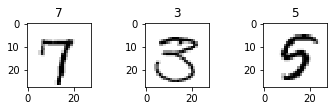

In [12]:
#Convert train datset to (num_images, img_rows, img_cols) format 
X_train = X_train.reshape(X_train.shape[0], 28, 28)

for i in range(6, 9):
    plt.subplot(330 + (i+1))
    plt.imshow(X_train[i], cmap=plt.get_cmap('gray_r'))
    plt.title(y_train[i]);

In [13]:
#expand 1 more dimention as 1 for colour channel gray
X_train = X_train.reshape(X_train.shape[0], 28, 28,1)
X_train.shape

(42000, 28, 28, 1)

In [14]:
X_test = X_test.reshape(X_test.shape[0], 28, 28,1)
X_test.shape

(28000, 28, 28, 1)

**Preprocessing the digit images**
==================================

**Feature Standardization**
-------------------------------------

It is important preprocessing step.
It is used to centre the data around zero mean and unit variance.

In [15]:
mean_px = X_train.mean().astype(np.float32)
std_px = X_train.std().astype(np.float32)

def standardize(x): 
    return (x-mean_px)/std_px

*One Hot encoding of labels.*
-----------------------------

A one-hot vector is a vector which is 0 in most dimensions, and 1 in a single dimension. In this case, the nth digit will be represented as a vector which is 1 in the nth dimension. 

For example, 3 would be [0,0,0,1,0,0,0,0,0,0].

In [16]:
from keras.utils.np_utils import to_categorical
y_train= to_categorical(y_train)
num_classes = y_train.shape[1]
num_classes

10

Lets plot 10th label.

/usr/local/lib/python3.7/site-packages/matplotlib/text.py:1150: FutureWarning: elementwise comparison failed; returning scalar instead, but in the future will perform elementwise comparison
  if s != self._text:


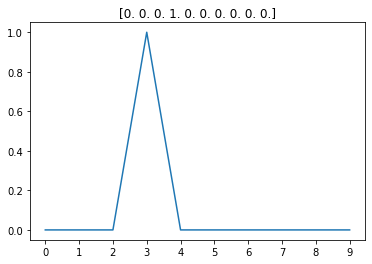

In [17]:
plt.title(y_train[9])
plt.plot(y_train[9])
plt.xticks(range(10));

Oh its 3 !

**Designing Neural Network Architecture**
=========================================

In [18]:
# fix random seed for reproducibility
seed = 43
np.random.seed(seed)

*Linear Model*
--------------

In [19]:
from keras.models import  Sequential
from keras.layers.core import  Lambda , Dense, Flatten, Dropout
from keras.callbacks import EarlyStopping
from keras.layers import BatchNormalization, Convolution2D , MaxPooling2D

Lets create a simple model from Keras Sequential layer.

1. Lambda layer performs simple arithmetic operations like sum, average, exponentiation etc.

 In 1st layer of the model we have to define input dimensions of our data in (rows,columns,colour channel) format.
 (In theano colour channel comes first)


2. Flatten will transform input into 1D array.


3. Dense is fully connected layer that means all neurons in previous layers will be connected to all neurons in fully connected layer.
 In the last layer we have to specify output dimensions/classes of the model.
 Here it's 10, since we have to output 10 different digit labels.

In [20]:
model= Sequential()
model.add(Lambda(standardize,input_shape=(28,28,1)))
model.add(Flatten())
model.add(Dense(10, activation='softmax'))
print("input shape ",model.input_shape)
print("output shape ",model.output_shape)

W0624 09:59:34.535813 4634289600 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:74: The name tf.get_default_graph is deprecated. Please use tf.compat.v1.get_default_graph instead.

W0624 09:59:34.550372 4634289600 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:517: The name tf.placeholder is deprecated. Please use tf.compat.v1.placeholder instead.

W0624 09:59:34.632287 4634289600 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:4138: The name tf.random_uniform is deprecated. Please use tf.random.uniform instead.



input shape  (None, 28, 28, 1)
output shape  (None, 10)


***Compile network***
-------------------

Before making network ready for training we have to make sure to add below things:

 1.  A loss function: to measure how good the network is
    
 2.  An optimizer: to update network as it sees more data and reduce loss
    value
    
 3.  Metrics: to monitor performance of network

In [21]:
from keras.optimizers import RMSprop
model.compile(optimizer=RMSprop(lr=0.001),
 loss='categorical_crossentropy',
 metrics=['accuracy'])

W0624 09:59:37.087071 4634289600 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/optimizers.py:790: The name tf.train.Optimizer is deprecated. Please use tf.compat.v1.train.Optimizer instead.

W0624 09:59:37.093498 4634289600 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:3295: The name tf.log is deprecated. Please use tf.math.log instead.



In [22]:
from keras.preprocessing import image
gen = image.ImageDataGenerator()

## Cross Validation 

In [23]:
from sklearn.model_selection import train_test_split
X = X_train
y = y_train
X_train, X_val, y_train, y_val = train_test_split(X_train, y_train, test_size=0.10, random_state=42)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches=gen.flow(X_val, y_val, batch_size=64)

In [24]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3, 
                    validation_data=val_batches, validation_steps=val_batches.n)

W0624 09:59:43.208245 4634289600 deprecation.py:323] From /usr/local/lib/python3.7/site-packages/tensorflow/python/ops/math_grad.py:1250: add_dispatch_support.<locals>.wrapper (from tensorflow.python.ops.array_ops) is deprecated and will be removed in a future version.
Instructions for updating:
Use tf.where in 2.0, which has the same broadcast rule as np.where
W0624 09:59:43.251929 4634289600 deprecation_wrapper.py:119] From /usr/local/lib/python3.7/site-packages/keras/backend/tensorflow_backend.py:986: The name tf.assign_add is deprecated. Please use tf.compat.v1.assign_add instead.



Epoch 1/3
37800/37800 [==============================] - 64s 2ms/step - loss: 0.2401 - acc: 0.9342 - val_loss: 0.3294 - val_acc: 0.9145
Epoch 2/3
37800/37800 [==============================] - 63s 2ms/step - loss: 0.2156 - acc: 0.9417 - val_loss: 0.3547 - val_acc: 0.9072
Epoch 3/3
37800/37800 [==============================] - 63s 2ms/step - loss: 0.2099 - acc: 0.9437 - val_loss: 0.3724 - val_acc: 0.9072


In [25]:
history_dict = history.history
history_dict.keys()

dict_keys(['val_loss', 'val_acc', 'loss', 'acc'])

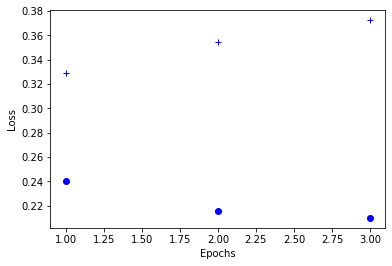

In [26]:
import matplotlib.pyplot as plt
%matplotlib inline
loss_values = history_dict['loss']
val_loss_values = history_dict['val_loss']
epochs = range(1, len(loss_values) + 1)

# "bo" is for "blue dot"
plt.plot(epochs, loss_values, 'bo')
# b+ is for "blue crosses"
plt.plot(epochs, val_loss_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Loss')

plt.show()

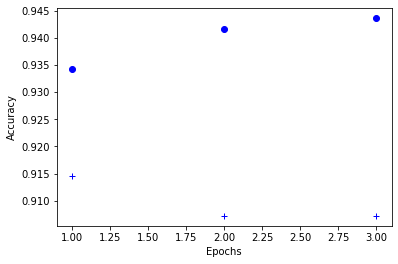

In [27]:
plt.clf()   # clear figure
acc_values = history_dict['acc']
val_acc_values = history_dict['val_acc']

plt.plot(epochs, acc_values, 'bo')
plt.plot(epochs, val_acc_values, 'b+')
plt.xlabel('Epochs')
plt.ylabel('Accuracy')

plt.show()

## Fully Connected Model

Neurons in a fully connected layer have full connections to all activations in the previous layer, as seen in regular Neural Networks. 
Adding another Dense Layer to model.

In [28]:
def get_fc_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(optimizer='Adam', loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [29]:
fc = get_fc_model()
fc.optimizer.lr=0.01

In [30]:
history=fc.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/1
37800/37800 [==============================] - 178s 5ms/step - loss: 0.1598 - acc: 0.9715 - val_loss: 0.5633 - val_acc: 0.9488


## Convolutional Neural Network
CNNs are extremely efficient for images.


In [53]:
from keras.layers import Convolution2D, MaxPooling2D

def get_cnn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        Convolution2D(64,(3,3), activation='relu'),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        Dense(512, activation='relu'),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy',
                  metrics=['accuracy'])
    return model

In [54]:
model= get_cnn_model()
model.optimizer.lr=0.01

In [55]:
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/1
42000/42000 [==============================] - 3044s 72ms/step - loss: 0.6667 - acc: 0.9467 - val_loss: 5.9925 - val_acc: 0.6282


## Data Augmentation
It is tehnique of showing slighly different or new images to neural network to avoid overfitting. And  to achieve better generalization.
In case you have very small dataset, you can use different kinds of data augmentation techniques to increase your data size. Neural networks perform better if you provide them more data.

Different data aumentation techniques are as follows:
1. Cropping
2. Rotating
3. Scaling
4. Translating
5. Flipping 
6. Adding Gaussian noise to input images etc.


In [34]:
gen =ImageDataGenerator(rotation_range=8, width_shift_range=0.08, shear_range=0.3,
                               height_shift_range=0.08, zoom_range=0.08)
batches = gen.flow(X_train, y_train, batch_size=64)
val_batches = gen.flow(X_val, y_val, batch_size=64)

In [35]:
model.optimizer.lr=0.001
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/1
37800/37800 [==============================] - 2865s 76ms/step - loss: 7.0282 - acc: 0.5639 - val_loss: 8.1427 - val_acc: 0.4948


## Adding Batch Normalization

BN helps to fine tune hyperparameters more better and train really deep neural networks.

In [36]:
from keras.layers.normalization import BatchNormalization

def get_bn_model():
    model = Sequential([
        Lambda(standardize, input_shape=(28,28,1)),
        Convolution2D(32,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(32,(3,3), activation='relu'),
        MaxPooling2D(),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        BatchNormalization(axis=1),
        Convolution2D(64,(3,3), activation='relu'),
        MaxPooling2D(),
        Flatten(),
        BatchNormalization(),
        Dense(512, activation='relu'),
        BatchNormalization(),
        Dense(10, activation='softmax')
        ])
    model.compile(Adam(), loss='categorical_crossentropy', metrics=['accuracy'])
    return model

In [37]:
model= get_bn_model()
model.optimizer.lr=0.01
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=1, 
                    validation_data=val_batches, validation_steps=val_batches.n)

Epoch 1/1
37800/37800 [==============================] - 4002s 106ms/step - loss: 0.0344 - acc: 0.9902 - val_loss: 0.0510 - val_acc: 0.9914


## Saving model to ONNX format

In [38]:
model.optimizer.lr=0.01
gen = image.ImageDataGenerator()
batches = gen.flow(X, y, batch_size=64)
history=model.fit_generator(generator=batches, steps_per_epoch=batches.n, epochs=3)

Epoch 1/3
42000/42000 [==============================] - 4374s 104ms/step - loss: 0.0140 - acc: 0.9981
Epoch 2/3
42000/42000 [==============================] - 4278s 102ms/step - loss: 0.0214 - acc: 0.9983
Epoch 3/3
42000/42000 [==============================] - 57188s 1s/step - loss: 0.0288 - acc: 0.9980


In [62]:
# Convert into ONNX format with onnxmltools
import keras2onnx
onnx_model = keras2onnx.convert_keras(model, model.name)

import onnx
temp_model_file = 'model.onnx'

onnx.save_model(onnx_model, temp_model_file)

In [57]:
print(str(onnx_model)[:500] + "\n...")

ir_version: 5
producer_name: "keras2onnx"
producer_version: "1.5.0"
domain: "onnx"
model_version: 0
doc_string: ""
graph {
  node {
    input: "lambda_5_input_01"
    input: "TFNodes1_lambda_5_sub_y_0"
    output: "TFNodes1_lambda_5_sub_0"
    name: "TFNodes1_lambda_5_sub"
    op_type: "Sub"
    doc_string: ""
    domain: ""
  }
  node {
    input: "TFNodes1_lambda_5_sub_0"
    input: "TFNodes1_lambda_5_truediv_y_0"
    output: "TFNodes1_lambda_5_truediv_0"
    name: "TFNodes1_lambda_5_truediv"

...


In [60]:
content = onnx_model.SerializeToString()
sess = onnxruntime.InferenceSession('model.onnx')

In [61]:
onnx.checker.check_model(onnx_model)